# Week 8, Day 2: Gradient Boosting (XGBoost, LightGBM)

## Learning Objectives
- Understand gradient boosting mechanics
- Implement XGBoost and LightGBM for trading
- Tune hyperparameters for financial data
- Compare boosting vs bagging approaches

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Try importing XGBoost and LightGBM
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
    print("XGBoost available")
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost not installed. Using sklearn GradientBoosting.")

try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
    print("LightGBM available")
except ImportError:
    LGB_AVAILABLE = False
    print("LightGBM not installed. Using sklearn GradientBoosting.")

XGBoost available
LightGBM available


In [15]:
# Load and prepare data
data_path = '../datasets/raw_data/combined_adjusted_close.csv'
prices = pd.read_csv(data_path, index_col='Date', parse_dates=True)

def create_ml_features(price_series):
    """Create ML features with proper lagging."""
    df = pd.DataFrame(index=price_series.index)
    
    # Returns
    df['ret_1d'] = price_series.pct_change(1).shift(1)
    df['ret_5d'] = price_series.pct_change(5).shift(1)
    df['ret_10d'] = price_series.pct_change(10).shift(1)
    df['ret_20d'] = price_series.pct_change(20).shift(1)
    
    # Moving averages
    df['sma_5'] = price_series.rolling(5).mean().shift(1)
    df['sma_20'] = price_series.rolling(20).mean().shift(1)
    df['sma_50'] = price_series.rolling(50).mean().shift(1)
    
    # Price relative to MAs
    df['price_to_sma5'] = (price_series.shift(1) / df['sma_5']) - 1
    df['price_to_sma20'] = (price_series.shift(1) / df['sma_20']) - 1
    df['sma5_to_sma20'] = (df['sma_5'] / df['sma_20']) - 1
    
    # Volatility
    df['volatility_10d'] = price_series.pct_change().rolling(10).std().shift(1)
    df['volatility_20d'] = price_series.pct_change().rolling(20).std().shift(1)
    df['vol_ratio'] = df['volatility_10d'] / df['volatility_20d']
    
    # RSI
    delta = price_series.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    df['rsi'] = (100 - 100 / (1 + gain / loss)).shift(1)
    
    # Target
    df['target_return'] = price_series.pct_change(1).shift(-1)
    df['target_direction'] = (df['target_return'] > 0).astype(int)
    
    return df.dropna()

# Create features for SPY
spy_data = create_ml_features(prices['SPY'])
feature_cols = [c for c in spy_data.columns if 'target' not in c]

X = spy_data[feature_cols]
y = spy_data['target_direction']

# Time series split
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {len(feature_cols)}")

Training samples: 72
Test samples: 18
Features: 14


## 1. Sklearn Gradient Boosting

In [16]:
# Gradient Boosting with different learning rates
learning_rates = [0.01, 0.05, 0.1, 0.2]
gb_results = []

for lr in learning_rates:
    gb = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=lr,
        max_depth=3,
        subsample=0.8,
        random_state=42
    )
    gb.fit(X_train, y_train)
    
    train_acc = gb.score(X_train, y_train)
    test_acc = gb.score(X_test, y_test)
    
    gb_results.append({
        'learning_rate': lr,
        'train_acc': train_acc,
        'test_acc': test_acc
    })

print("Gradient Boosting: Learning Rate Comparison")
print("="*50)
print(pd.DataFrame(gb_results).to_string(index=False))

Gradient Boosting: Learning Rate Comparison
 learning_rate  train_acc  test_acc
          0.01   0.944444  0.611111
          0.05   1.000000  0.555556
          0.10   1.000000  0.611111
          0.20   1.000000  0.611111


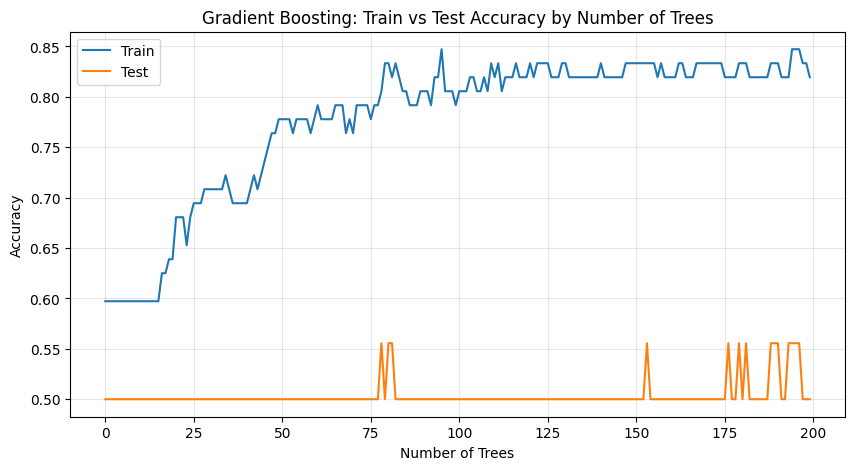


Best test accuracy: 0.5556 at 79 trees


In [17]:
# Optimal GB model
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    min_samples_leaf=20,
    subsample=0.8,
    random_state=42
)
gb_model.fit(X_train, y_train)

# Staged predictions (see how performance evolves with more trees)
train_scores = []
test_scores = []

for i, (y_train_pred, y_test_pred) in enumerate(zip(
    gb_model.staged_predict(X_train),
    gb_model.staged_predict(X_test)
)):
    train_scores.append(accuracy_score(y_train, y_train_pred))
    test_scores.append(accuracy_score(y_test, y_test_pred))

plt.figure(figsize=(10, 5))
plt.plot(train_scores, label='Train')
plt.plot(test_scores, label='Test')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Gradient Boosting: Train vs Test Accuracy by Number of Trees')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nBest test accuracy: {max(test_scores):.4f} at {np.argmax(test_scores)+1} trees")

## 2. XGBoost Implementation

In [18]:
if XGB_AVAILABLE:
    # XGBoost model
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    # Train with early stopping
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
    )
    
    print("XGBoost Results")
    print("="*50)
    print(f"Training accuracy: {xgb_model.score(X_train, y_train):.4f}")
    print(f"Test accuracy: {xgb_model.score(X_test, y_test):.4f}")
    
    # Feature importance
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 5 Features:")
    print(importance.head())
else:
    print("XGBoost not available. Install with: pip install xgboost")

XGBoost Results
Training accuracy: 1.0000
Test accuracy: 0.6111

Top 5 Features:
      feature  importance
3     ret_20d    0.092617
13        rsi    0.089369
1      ret_5d    0.082985
12  vol_ratio    0.082810
2     ret_10d    0.076431


In [19]:
if XGB_AVAILABLE:
    # XGBoost hyperparameter search
    param_grid = [
        {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 100},
        {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100},
        {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 100},
        {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 200},
        {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 200},
    ]
    
    xgb_results = []
    for params in param_grid:
        model = xgb.XGBClassifier(
            **params,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )
        model.fit(X_train, y_train, verbose=False)
        
        xgb_results.append({
            **params,
            'train_acc': model.score(X_train, y_train),
            'test_acc': model.score(X_test, y_test)
        })
    
    print("XGBoost Hyperparameter Search")
    print("="*70)
    print(pd.DataFrame(xgb_results).to_string(index=False))

XGBoost Hyperparameter Search
 max_depth  learning_rate  n_estimators  train_acc  test_acc
         3           0.05           100   0.972222  0.500000
         3           0.10           100   1.000000  0.611111
         5           0.05           100   0.986111  0.555556
         5           0.05           200   1.000000  0.555556
         3           0.05           200   1.000000  0.611111


## 3. LightGBM Implementation

In [20]:
if LGB_AVAILABLE:
    # LightGBM model
    lgb_model = lgb.LGBMClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        num_leaves=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.1,
        random_state=42,
        verbosity=-1
    )
    
    lgb_model.fit(X_train, y_train)
    
    print("LightGBM Results")
    print("="*50)
    print(f"Training accuracy: {lgb_model.score(X_train, y_train):.4f}")
    print(f"Test accuracy: {lgb_model.score(X_test, y_test):.4f}")
    
    # Feature importance
    importance_lgb = pd.DataFrame({
        'feature': feature_cols,
        'importance': lgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 5 Features:")
    print(importance_lgb.head())
else:
    print("LightGBM not available. Install with: pip install lightgbm")

LightGBM Results
Training accuracy: 0.9028
Test accuracy: 0.6667

Top 5 Features:
           feature  importance
13             rsi          81
3          ret_20d          60
11  volatility_20d          49
0           ret_1d          41
1           ret_5d          35


## 4. Model Comparison

In [21]:
# Compare all models
from sklearn.ensemble import RandomForestClassifier

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42),
}

if XGB_AVAILABLE:
    models['XGBoost'] = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, 
                                          random_state=42, use_label_encoder=False, eval_metric='logloss')
if LGB_AVAILABLE:
    models['LightGBM'] = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, 
                                            random_state=42, verbosity=-1)

comparison_results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    # Get probabilities for AUC
    proba_test = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, proba_test)
    
    comparison_results.append({
        'Model': name,
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'Test AUC': auc
    })

print("Model Comparison")
print("="*60)
comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string(index=False))

Model Comparison
            Model  Train Acc  Test Acc  Test AUC
    Random Forest   0.986111  0.555556  0.629630
Gradient Boosting   1.000000  0.555556  0.641975
          XGBoost   1.000000  0.500000  0.611111
         LightGBM   0.888889  0.555556  0.592593


## 5. Trading Strategy with Gradient Boosting

In [22]:
# Use best model for trading
best_model = gb_model  # Or xgb_model/lgb_model if available

# Get predictions and probabilities
proba_test = best_model.predict_proba(X_test)[:, 1]

# Create confidence-based signals
def create_trading_signals(proba, high_thresh=0.55, low_thresh=0.45):
    signals = np.zeros(len(proba))
    signals[proba > high_thresh] = 1   # Long
    signals[proba < low_thresh] = -1   # Short
    return signals

signals = create_trading_signals(proba_test)

# Calculate returns
actual_returns = spy_data.loc[X_test.index, 'target_return']
strategy_returns = signals * actual_returns.values

# Performance metrics
total_return = (1 + strategy_returns).prod() - 1
sharpe = np.sqrt(252) * strategy_returns.mean() / strategy_returns.std() if strategy_returns.std() > 0 else 0
win_rate = (strategy_returns > 0).sum() / (signals != 0).sum() if (signals != 0).sum() > 0 else 0

# Buy and hold comparison
bh_return = (1 + actual_returns).prod() - 1
bh_sharpe = np.sqrt(252) * actual_returns.mean() / actual_returns.std()

print("Trading Strategy Performance")
print("="*50)
print(f"\n{'Metric':<20} | {'Strategy':>12} | {'Buy & Hold':>12}")
print("-"*50)
print(f"{'Total Return':<20} | {total_return:>11.2%} | {bh_return:>11.2%}")
print(f"{'Sharpe Ratio':<20} | {sharpe:>12.2f} | {bh_sharpe:>12.2f}")
print(f"{'Win Rate':<20} | {win_rate:>11.2%} | {'N/A':>12}")
print(f"{'# Trades':<20} | {int((signals != 0).sum()):>12} | {'N/A':>12}")

Trading Strategy Performance

Metric               |     Strategy |   Buy & Hold
--------------------------------------------------
Total Return         |       0.90% |      -0.23%
Sharpe Ratio         |         0.91 |        -0.11
Win Rate             |      53.33% |          N/A
# Trades             |           15 |          N/A


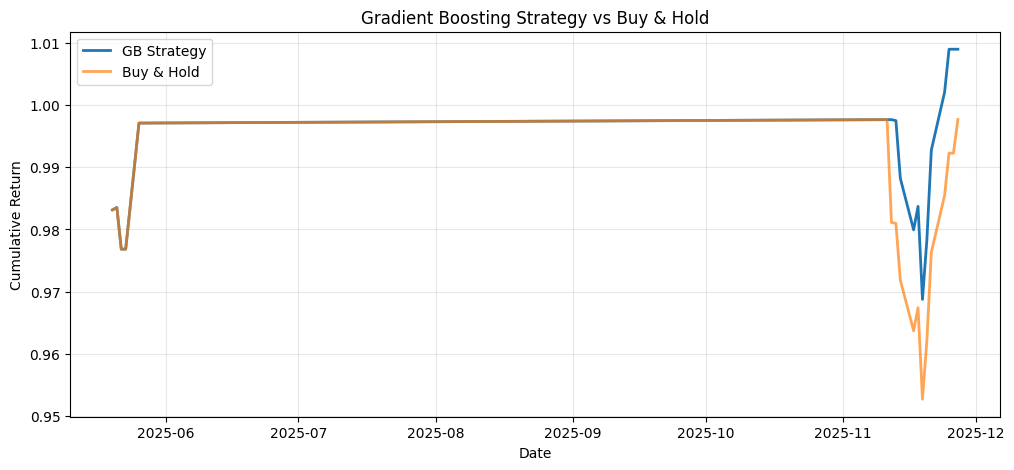

In [23]:
# Cumulative returns plot
cum_strategy = (1 + pd.Series(strategy_returns, index=X_test.index)).cumprod()
cum_buyhold = (1 + actual_returns).cumprod()

plt.figure(figsize=(12, 5))
plt.plot(cum_strategy, label='GB Strategy', linewidth=2)
plt.plot(cum_buyhold, label='Buy & Hold', linewidth=2, alpha=0.7)
plt.title('Gradient Boosting Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. Practice Exercises

1. **Early Stopping**: Implement proper early stopping with a validation set.

2. **Regularization**: Experiment with different regularization parameters (lambda, alpha).

3. **Threshold Optimization**: Find optimal probability thresholds using the validation set.

4. **Multi-Class**: Predict 3 classes (strong up, neutral, strong down).

In [24]:
# Exercise: Threshold optimization
thresholds = np.arange(0.50, 0.65, 0.01)
threshold_results = []

for thresh in thresholds:
    signals = create_trading_signals(proba_test, high_thresh=thresh, low_thresh=1-thresh)
    strategy_rets = signals * actual_returns.values
    
    # Only evaluate if we have trades
    n_trades = (signals != 0).sum()
    if n_trades > 10:
        sharpe = np.sqrt(252) * strategy_rets.mean() / strategy_rets.std() if strategy_rets.std() > 0 else 0
        threshold_results.append({
            'threshold': thresh,
            'n_trades': n_trades,
            'sharpe': sharpe,
            'total_return': (1 + strategy_rets).prod() - 1
        })

thresh_df = pd.DataFrame(threshold_results)
print("Threshold Optimization Results")
print("="*50)
print(thresh_df.to_string(index=False))

Threshold Optimization Results
 threshold  n_trades    sharpe  total_return
      0.50        18 -1.047375     -0.013131
      0.51        17 -0.584542     -0.007714
      0.52        16 -0.584542     -0.007714
      0.53        15  0.912352      0.009030
      0.54        15  0.912352      0.009030
      0.55        15  0.912352      0.009030
      0.56        15  0.912352      0.009030
      0.57        15  0.912352      0.009030
      0.58        14  0.927646      0.009195
      0.59        13  0.927646      0.009195
      0.60        13  0.927646      0.009195
      0.61        13  0.927646      0.009195
      0.62        13  0.927646      0.009195
      0.63        13  0.927646      0.009195
      0.64        13  0.927646      0.009195
      0.65        12 -1.179048     -0.011360


## Summary

Today we learned:
- Gradient boosting builds trees sequentially, each correcting the previous
- XGBoost and LightGBM are optimized implementations with regularization
- Learning rate and n_estimators have a tradeoff
- Feature importance helps understand what drives predictions
- Confidence thresholds turn probabilities into trading signals